# Quick Initial Analysis

In [1]:
from pathlib import Path
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils.pipeline import (
    load_combined_dataset,
    run_preprocessing_pipeline,
    ohe_features,
)
from src.feature_config import (
    EQ_FEATURES,
    MORPHOLOGY_FEATURES,
    ALL_CONTINUOUS_FEATURES,
    ALL_CATEGORICAL_FEATURES,
    ALL_BINARY_FEATURES,
    POSSIBLE_TARGET_FEATURES,
)
from src.target_definition.aggregate import aggregate_health_targets
from src.feature_selection import compute_associations, compute_categorical_associations
from src.feature_selection.selection import filter_by_p_value, filter_by_vif
from src.predictive import run_modeling_suite

data_path = Path("data") / "morphology_data_integrated.csv"
df = pd.read_csv(data_path, sep=";", decimal=",")
df.head()

,id,left,top,right,bottom,row_index,col_index,field_1,PC1,PC2,...,Intersections,Length N-S,Length NE-SW,Length SE-NW,Length E-W,Length primary road,Length highway,Length secondary road,Length railway,Neighbourhood type
0,36,2497723.99,1118389.101,2497973.99,1118139.101,10,1,1343,0.526055,0.338480,...,17,112.14,420.48,83.42,561.10,0.000000,0,1177.140000,375.314,S-C
1,37,2497723.99,1118139.101,2497973.99,1117889.101,11,1,1344,0.851423,0.674067,...,17,267.99,412.77,336.30,412.39,520.689149,0,908.760851,0.000,S-C
2,38,2497723.99,1117889.101,2497973.99,1117639.101,12,1,1345,-0.752449,0.148228,...,1,86.55,183.10,0.00,13.60,0.000000,0,283.250000,0.000,S-D
3,39,2497723.99,1117639.101,2497973.99,1117389.101,13,1,1346,1.066390,-0.858294,...,0,0.00,0.00,0.00,0.00,0.000000,0,0.000000,0.000,S-D
4,40,2497723.99,1117389.101,2497973.99,1117139.101,14,1,1347,-0.433673,-0.642512,...,0,0.00,0.00,0.00,0.00,0.000000,0,0.000000,0.000,S-D


In [2]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Number of rows: 241
Number of features: 54


In [3]:
df["typology"].value_counts()

typology
A    58
E    42
J    27
B    26
C    25
G    25
D    20
I    12
F     5
K     1
Name: count, dtype: int64

In [4]:
# Standardize column names: lowercase and replace spaces with underscores
df = df.drop(columns=["City"])  # remove duplicate column
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_", regex=False)
df.head()

,id,left,top,right,bottom,row_index,col_index,field_1,pc1,pc2,...,intersections,length_n-s,length_ne-sw,length_se-nw,length_e-w,length_primary_road,length_highway,length_secondary_road,length_railway,neighbourhood_type
0,36,2497723.99,1118389.101,2497973.99,1118139.101,10,1,1343,0.526055,0.338480,...,17,112.14,420.48,83.42,561.10,0.000000,0,1177.140000,375.314,S-C
1,37,2497723.99,1118139.101,2497973.99,1117889.101,11,1,1344,0.851423,0.674067,...,17,267.99,412.77,336.30,412.39,520.689149,0,908.760851,0.000,S-C
2,38,2497723.99,1117889.101,2497973.99,1117639.101,12,1,1345,-0.752449,0.148228,...,1,86.55,183.10,0.00,13.60,0.000000,0,283.250000,0.000,S-D
3,39,2497723.99,1117639.101,2497973.99,1117389.101,13,1,1346,1.066390,-0.858294,...,0,0.00,0.00,0.00,0.00,0.000000,0,0.000000,0.000,S-D
4,40,2497723.99,1117389.101,2497973.99,1117139.101,14,1,1347,-0.433673,-0.642512,...,0,0.00,0.00,0.00,0.00,0.000000,0,0.000000,0.000,S-D


In [5]:
print(df.columns.unique())

Index(['id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index',
       'field_1', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'typology', 'city',
       'z_distance', 'q_cluster', 'lst_mean', 'solar_summ', 'solar_wint',
       'pm10_mean', 'pm25_mean', 'no2_mean', 'noiseday_m', 'noisenight',
       'bin_lst_me', 'bin_solar_', 'bin_sola_1', 'bin_pm10_m', 'bin_pm25_m',
       'bin_no2_me', 'bin_noised', 'bin_noisen', 'building_height',
       'height_varability', 'sky_view_factor', 'frontal_area_index',
       'water_cover_fraction', 'impervious_surface_cover_fraction',
       'building_cover_fraction', 'pervious_surface_cover_fraction',
       'aspect_ratio', 'intersections', 'length_n-s', 'length_ne-sw',
       'length_se-nw', 'length_e-w', 'length_primary_road', 'length_highway',
       'length_secondary_road', 'length_railway', 'neighbourhood_type'],
      dtype='object')


In [6]:
# Print the columns with unique values == len(df)

cols_to_remove = []
for col in df.columns:
    if col == "id":
        continue
    if df[col].nunique() == len(df) or df[col].nunique() <= 1:
        cols_to_remove.append(col)

print("Columns to remove: ", cols_to_remove)
df = df.drop(columns=cols_to_remove)

Columns to remove:  ['field_1', 'city', 'length_highway']


In [7]:
features_to_remove = [
    "left",
    "top",
    "right",
    "bottom",
    "row_index",
    "col_index",
    "q_cluster",
    "z_distance",
]
df = df.drop(columns=features_to_remove)
print(f"Numbers of columns after removing metadata features: {len(df.columns)}")
print(df.columns)

Numbers of columns after removing metadata features: 42
Index(['id', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'typology', 'lst_mean',
       'solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean',
       'noiseday_m', 'noisenight', 'bin_lst_me', 'bin_solar_', 'bin_sola_1',
       'bin_pm10_m', 'bin_pm25_m', 'bin_no2_me', 'bin_noised', 'bin_noisen',
       'building_height', 'height_varability', 'sky_view_factor',
       'frontal_area_index', 'water_cover_fraction',
       'impervious_surface_cover_fraction', 'building_cover_fraction',
       'pervious_surface_cover_fraction', 'aspect_ratio', 'intersections',
       'length_n-s', 'length_ne-sw', 'length_se-nw', 'length_e-w',
       'length_primary_road', 'length_secondary_road', 'length_railway',
       'neighbourhood_type'],
      dtype='object')


In [8]:
# Remove the columns with the "bin" prefix, as they are binned versions of other columns
bin_columns = [col for col in df.columns if col.startswith("bin")]
df = df.drop(columns=bin_columns)
print(f"Numbers of columns after removing binned features: {len(df.columns)}")
print(df.columns)

Numbers of columns after removing binned features: 34
Index(['id', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'typology', 'lst_mean',
       'solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean',
       'noiseday_m', 'noisenight', 'building_height', 'height_varability',
       'sky_view_factor', 'frontal_area_index', 'water_cover_fraction',
       'impervious_surface_cover_fraction', 'building_cover_fraction',
       'pervious_surface_cover_fraction', 'aspect_ratio', 'intersections',
       'length_n-s', 'length_ne-sw', 'length_se-nw', 'length_e-w',
       'length_primary_road', 'length_secondary_road', 'length_railway',
       'neighbourhood_type'],
      dtype='object')


In [9]:
# Print the rows where there are NaN values
original_rows_num = df.shape[0]
nan_rows = df[df.isna().any(axis=1)]
nan_rows
df.dropna(inplace=True)
print(f"Number of rows after dropping NaN values: {len(df)}")
print(f"Number of rows dropped: {original_rows_num - len(df)}")

Number of rows after dropping NaN values: 240
Number of rows dropped: 1


In [10]:
# Remove numeric columns with zero variance (constant columns)
numeric_cols = df.select_dtypes(include=["number"]).columns
zero_var_cols = [c for c in numeric_cols if abs(df[c].std()) <= 1e-8]
if zero_var_cols:
    print("Zero-variance numeric columns to remove:", zero_var_cols)
    df = df.drop(columns=zero_var_cols)
else:
    print("No zero-variance numeric columns found")
print(f"Columns remaining after removing zero-variance: {len(df.columns)}")

No zero-variance numeric columns found
Columns remaining after removing zero-variance: 34


In [11]:
# convert typology to categorical dtype
df["typology"] = df["typology"].astype("category")

In [12]:
# Save the cleaned dataframe
df.to_csv("data/morphology_data_cleaned.csv", index=False)

Compact **Exploratory Data Analysis (EDA)** of the cleaned morphological dataset regarding Geneva neighborhoods. Here we perform sanity checks, look at distributions, correlations, clustering tendencies as well as relationships between environmental quality and morphology-associated markers.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 240
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   id                                 240 non-null    int64   
 1   pc1                                240 non-null    float64 
 2   pc2                                240 non-null    float64 
 3   pc3                                240 non-null    float64 
 4   pc4                                240 non-null    float64 
 5   pc5                                240 non-null    float64 
 6   pc6                                240 non-null    float64 
 7   typology                           240 non-null    category
 8   lst_mean                           240 non-null    float64 
 9   solar_summ                         240 non-null    float64 
 10  solar_wint                         240 non-null    float64 
 11  pm10_mean                          240 non-null   

The features are already standardized, and they are also all continuous except for the id which is an integer and the typology which is a category

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,240.0,256.554167,110.487722,36.000000,166.750000,260.500000,344.250000,466.000000
pc1,240.0,-0.276652,0.990332,-4.838262,-0.906122,-0.138568,0.436716,1.921704
pc2,240.0,-0.007602,1.020836,-3.208794,-0.583750,0.038594,0.627072,4.381786
pc3,240.0,-0.133991,1.004006,-3.253529,-0.784161,-0.037030,0.458507,3.160354
pc4,240.0,-0.216103,0.944383,-3.014233,-0.888022,-0.258895,0.350770,2.422418
pc5,240.0,0.234959,0.814041,-2.517597,-0.379032,0.204648,0.693712,3.355186
pc6,240.0,0.268141,1.041847,-2.546661,-0.329660,0.208061,0.949746,4.888767
lst_mean,240.0,0.066048,1.013751,-2.398759,-0.698862,-0.043775,0.783261,2.719456
solar_summ,240.0,0.029420,1.028082,-3.959839,-0.407195,-0.205333,0.553019,5.038286
solar_wint,240.0,0.040750,0.994545,-2.147976,-0.514735,-0.192346,0.440508,4.570293


<Figure size 1200x800 with 0 Axes>

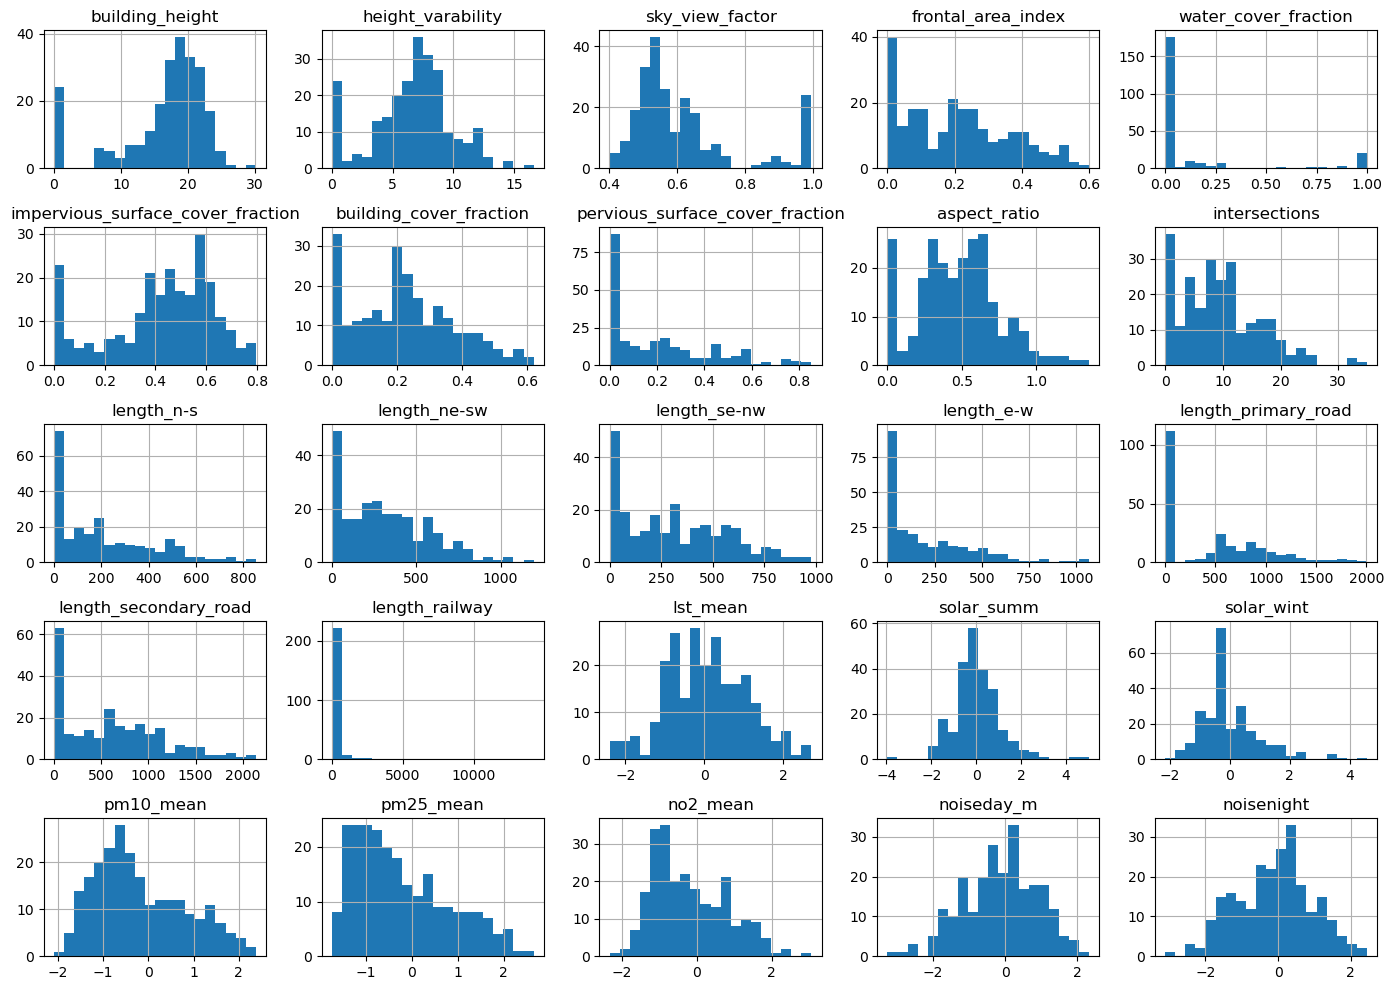

In [15]:
plt.figure(figsize=(12, 8))
df[MORPHOLOGY_FEATURES + EQ_FEATURES].hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

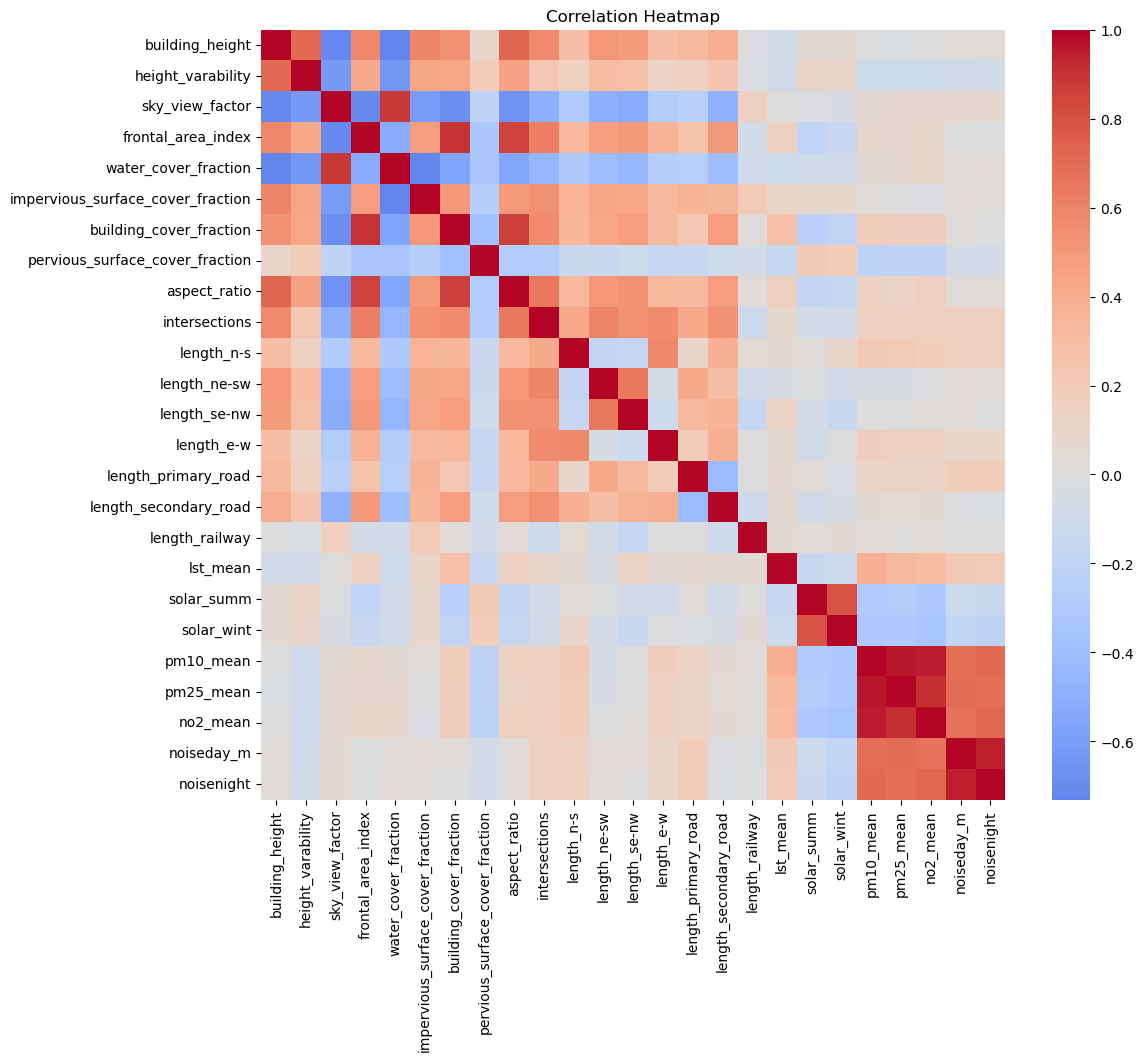

In [16]:
NUMERICAL_MORPHOLOGY_FEATURES = [
    feature for feature in MORPHOLOGY_FEATURES if feature in ALL_CONTINUOUS_FEATURES
]

plt.figure(figsize=(12, 10))
sns.heatmap(
    df[NUMERICAL_MORPHOLOGY_FEATURES + EQ_FEATURES].corr(),
    annot=False,
    cmap="coolwarm",
    center=0,
)
plt.title("Correlation Heatmap")
plt.show()

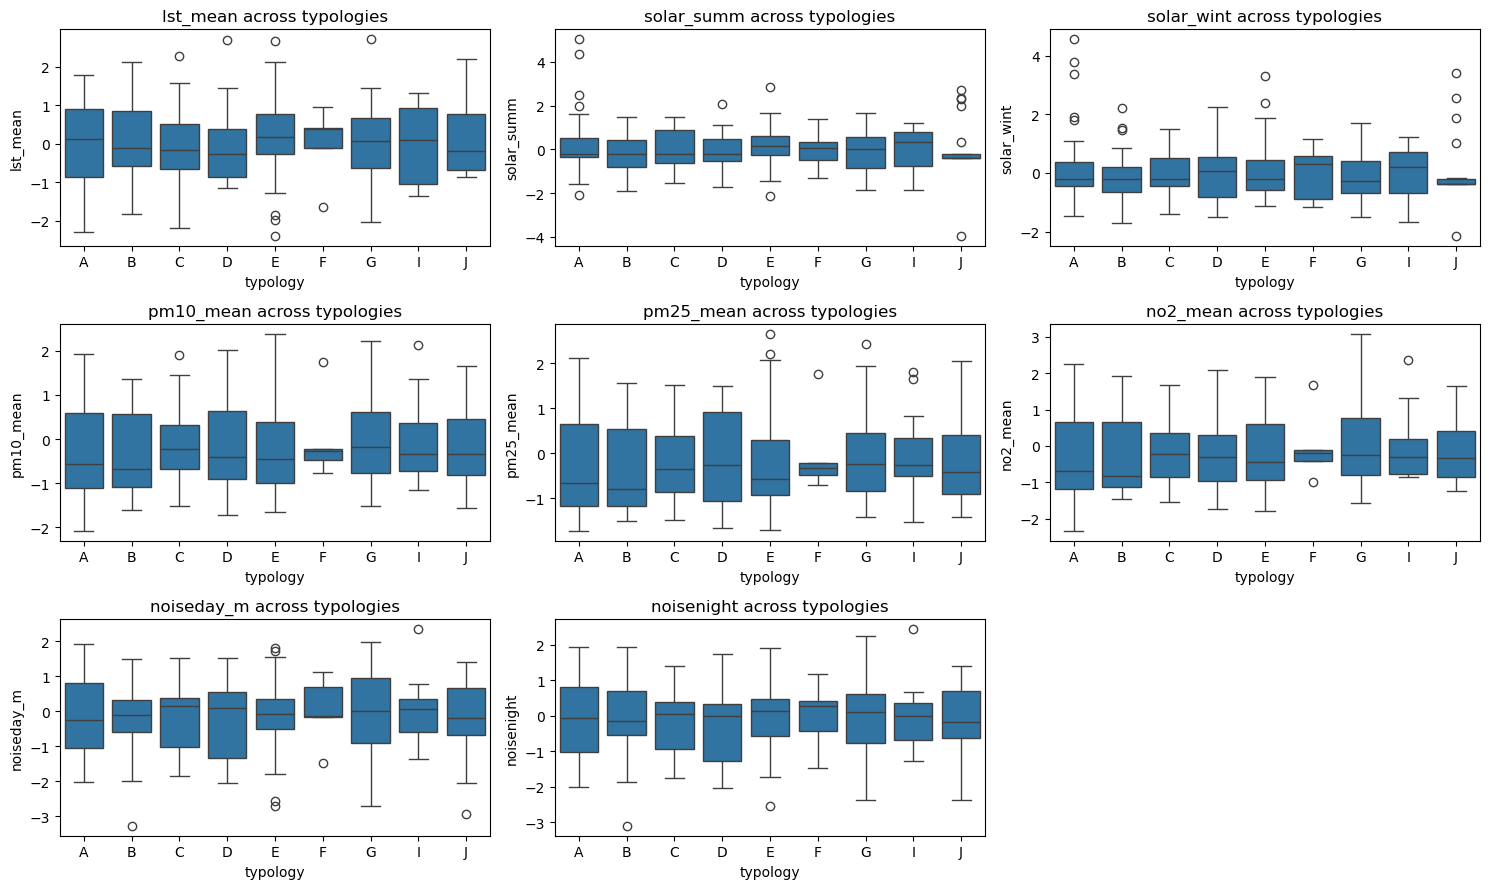

In [17]:
# arrange the env feature boxplots into a single grid of subplots
n = len(EQ_FEATURES)
cols = min(3, n)
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3), squeeze=False)
axes_flat = axes.flatten()

for ax, var in zip(axes_flat, EQ_FEATURES):
    sns.boxplot(data=df, x="typology", y=var, ax=ax)
    ax.set_title(f"{var} across typologies")
    plt.xticks(rotation=45)

# remove any unused axes (if n < rows*cols)
for ax in axes_flat[len(EQ_FEATURES) :]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

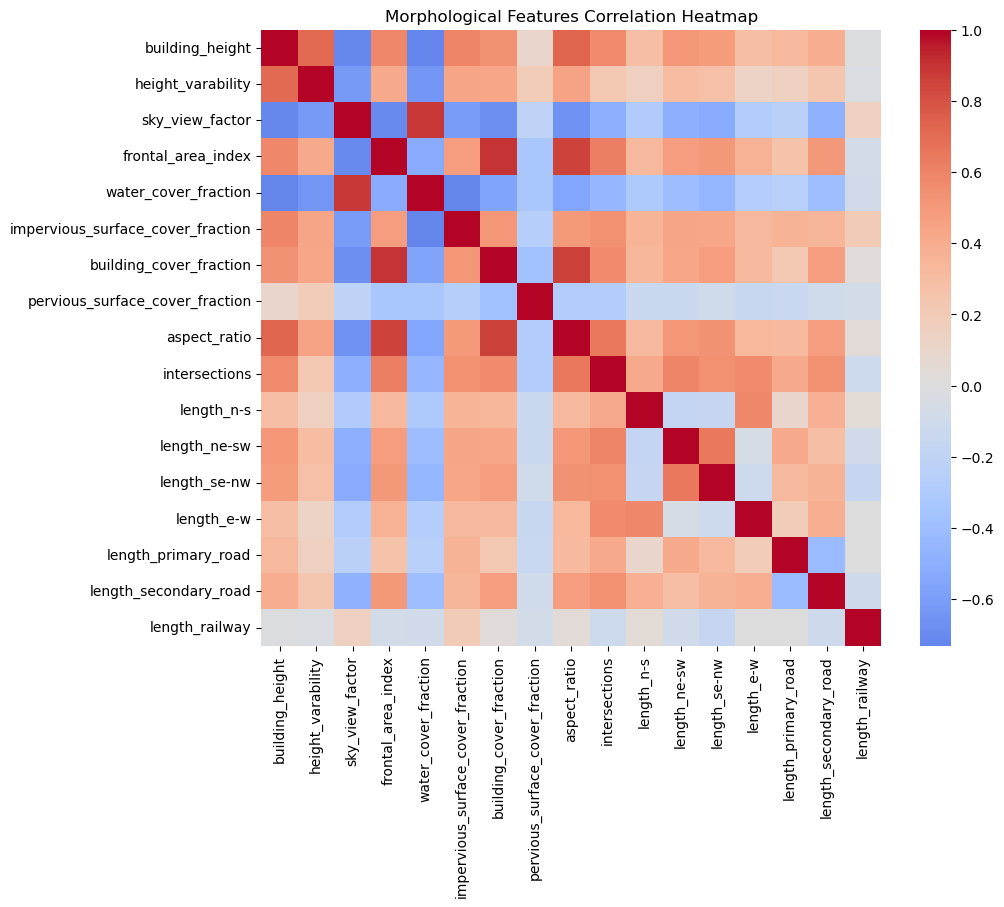

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[NUMERICAL_MORPHOLOGY_FEATURES].corr(), annot=False, cmap="coolwarm", center=0
)
plt.title("Morphological Features Correlation Heatmap")
plt.show()

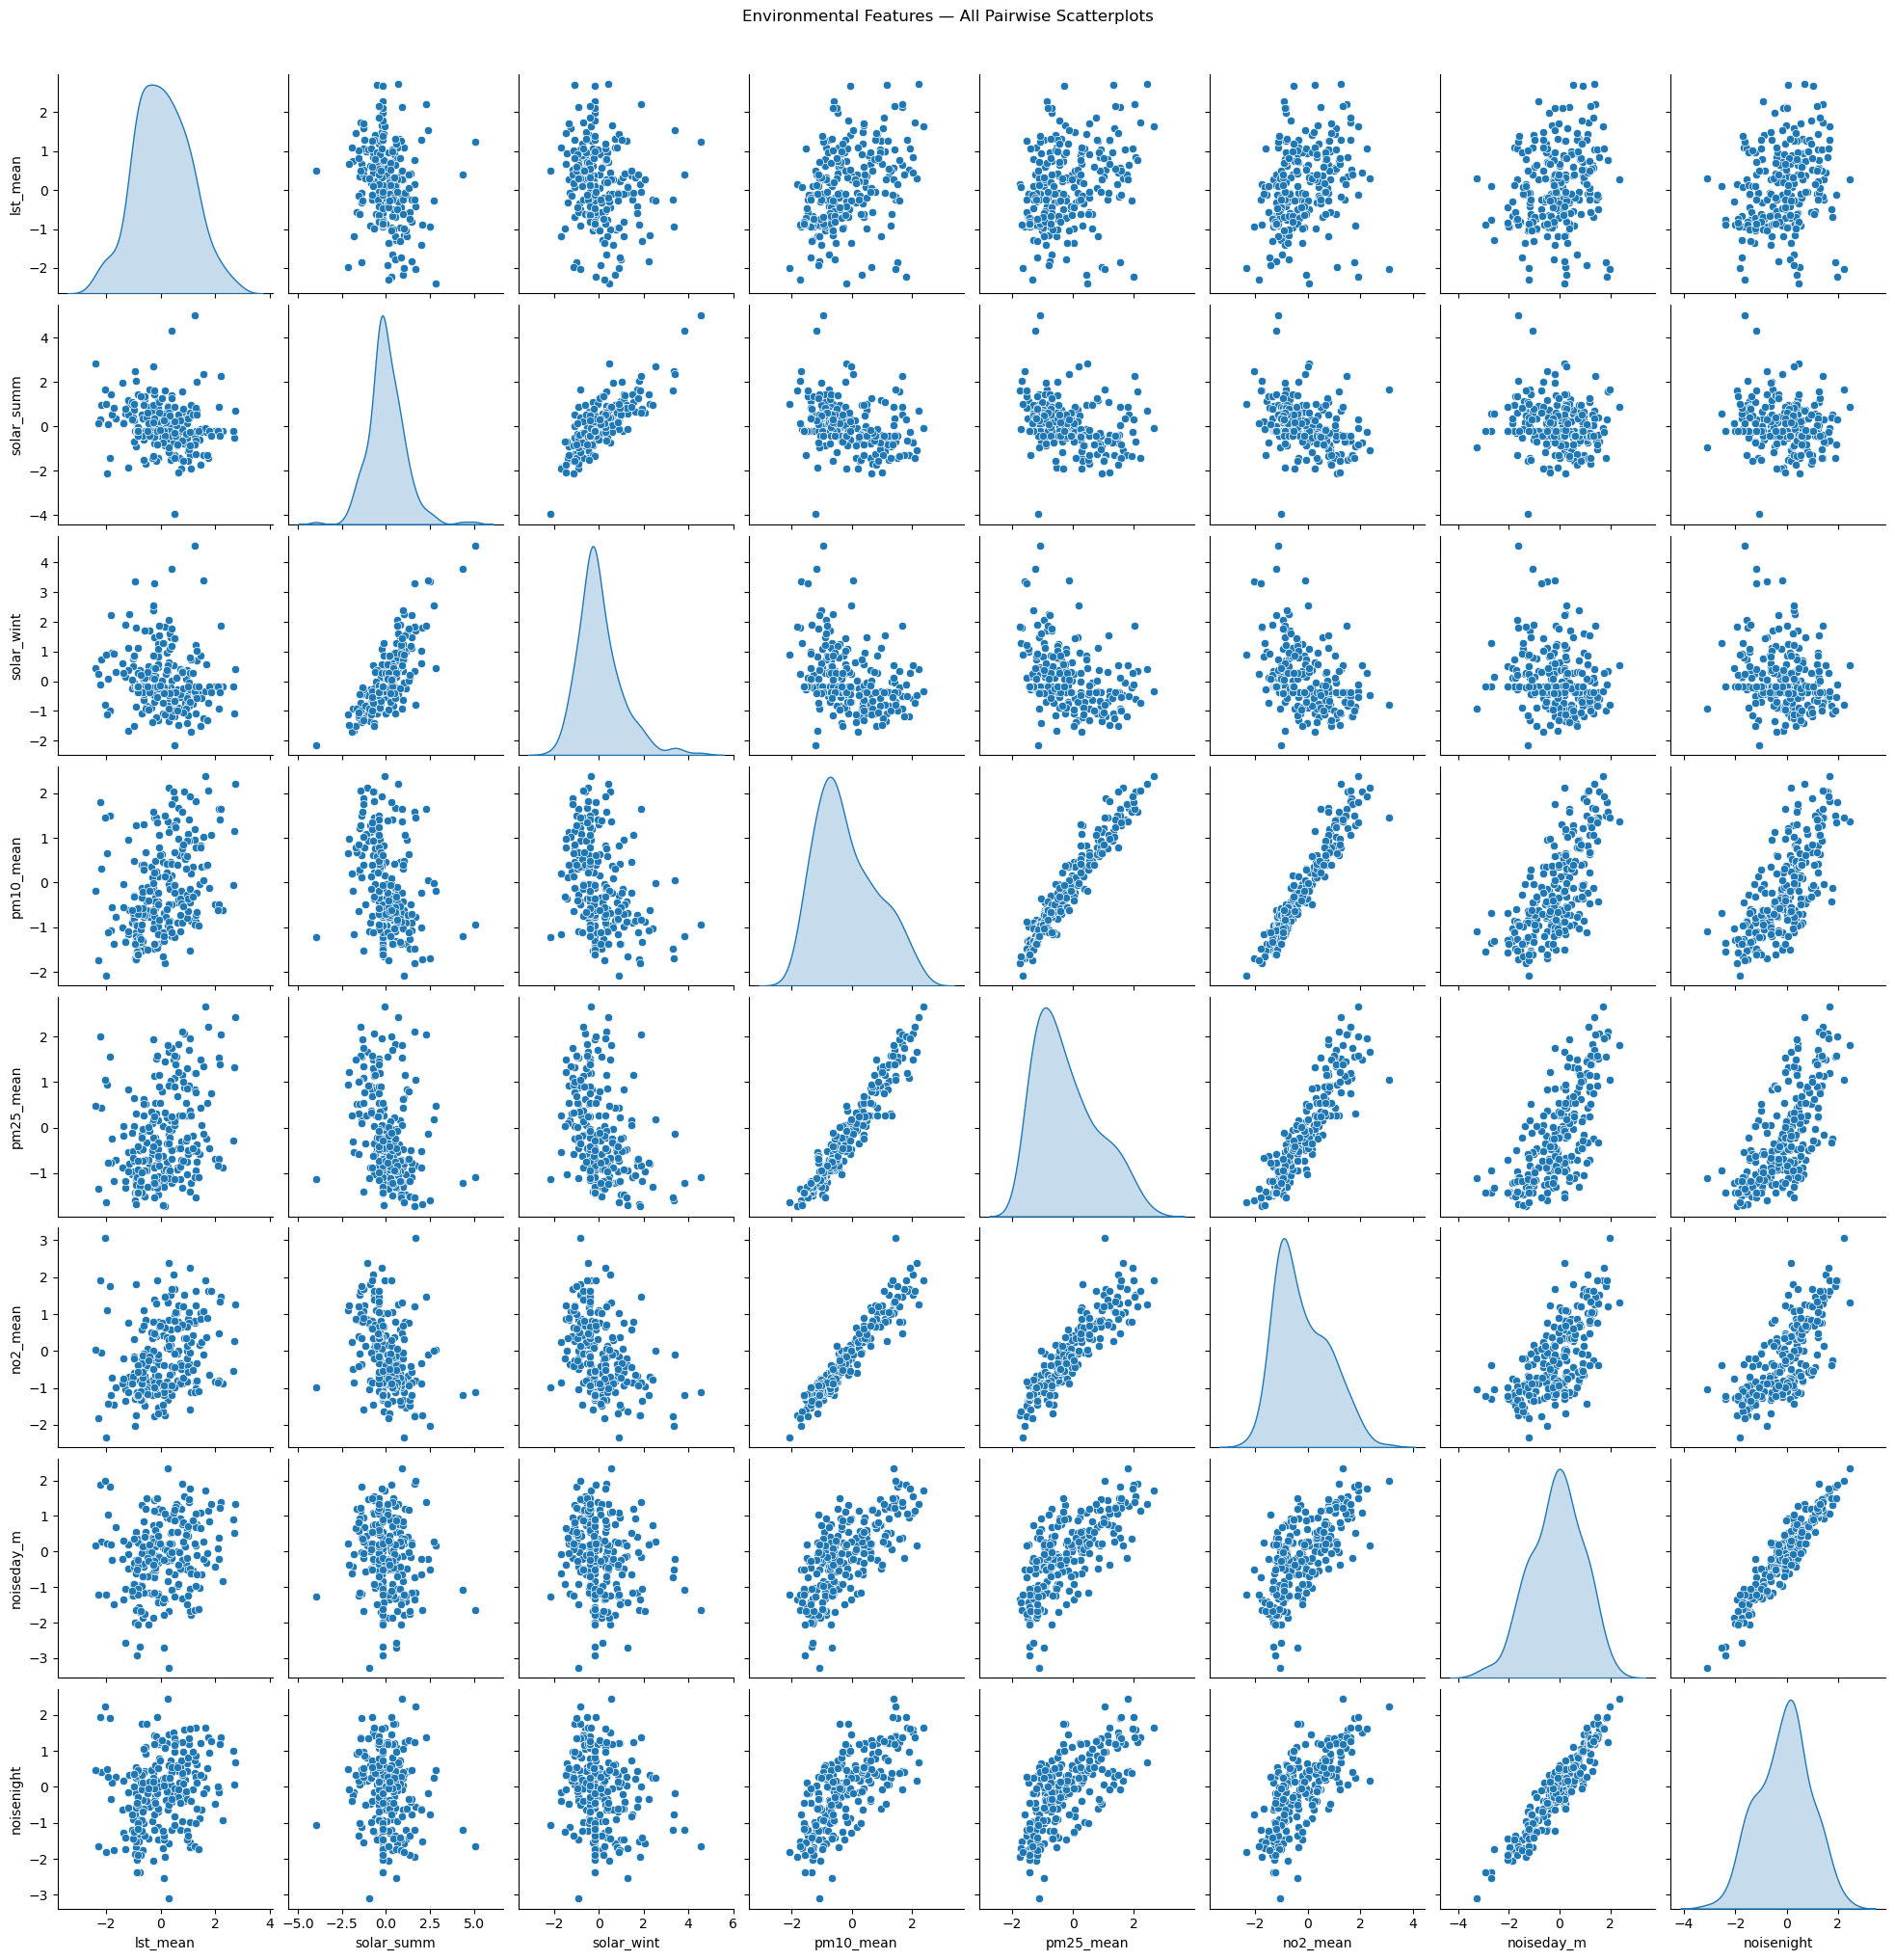

In [19]:
# pairplot for compact visual overview to show all pairwise scatter plots, maybe catch nonlinear relations
sns.pairplot(df[EQ_FEATURES], diag_kind="kde")
plt.suptitle("Environmental Features — All Pairwise Scatterplots", y=1.02)
plt.show()

# Pipeline

In [20]:
df = load_combined_dataset(
    "data/morphology_data_cleaned.csv",
    "data/synthetic_health_data.xlsx",
)
df = run_preprocessing_pipeline(df)
print(f"Final dataset shape: {df.shape}")

Final dataset shape: (2631, 40)


In [21]:
df.columns.to_list()

['typology',
 'lst_mean',
 'solar_summ',
 'solar_wint',
 'pm10_mean',
 'pm25_mean',
 'no2_mean',
 'noiseday_m',
 'noisenight',
 'building_height',
 'height_varability',
 'sky_view_factor',
 'frontal_area_index',
 'water_cover_fraction',
 'impervious_surface_cover_fraction',
 'building_cover_fraction',
 'pervious_surface_cover_fraction',
 'aspect_ratio',
 'intersections',
 'length_n-s',
 'length_ne-sw',
 'length_se-nw',
 'length_e-w',
 'length_primary_road',
 'length_secondary_road',
 'length_railway',
 'neighbourhood_type',
 'sex',
 'income',
 'education_level',
 'heart_failure',
 'heart_rhythm',
 'd_breath_respiratory',
 'd_breath_asthma',
 'GHQ12_score',
 'points_sleep_deprivation',
 'sleep_disorder_hot',
 'sleeping_hours',
 'bedtime_hour',
 'age_bin']

In [22]:
df.head()

,typology,lst_mean,solar_summ,solar_wint,pm10_mean,pm25_mean,no2_mean,noiseday_m,noisenight,building_height,...,heart_failure,heart_rhythm,d_breath_respiratory,d_breath_asthma,GHQ12_score,points_sleep_deprivation,sleep_disorder_hot,sleeping_hours,bedtime_hour,age_bin
0,C,-0.111053,1.130211,0.982144,-1.361464,-1.464034,-1.538696,-1.409763,-1.450883,15.782626,...,0,0,0,1,10,10,0,6.239702,1260.633333,1
1,C,-0.111053,1.130211,0.982144,-1.361464,-1.464034,-1.538696,-1.409763,-1.450883,15.782626,...,0,0,0,0,7,0,0,5.047253,1380.366667,3
2,C,-0.111053,1.130211,0.982144,-1.361464,-1.464034,-1.538696,-1.409763,-1.450883,15.782626,...,0,0,0,0,3,6,1,6.704064,1380.183333,2
3,C,-0.111053,1.130211,0.982144,-1.361464,-1.464034,-1.538696,-1.409763,-1.450883,15.782626,...,0,0,0,0,1,18,0,4.283209,1200.316667,2
4,C,-0.111053,1.130211,0.982144,-1.361464,-1.464034,-1.538696,-1.409763,-1.450883,15.782626,...,0,0,0,0,0,20,0,5.790631,1260.916667,3


We only have 14 continuous features so probably applying PCA doesn't make sense (also 6 of those 14 features are principal components of other data) 

In [23]:
print(
    f"Number of features that are continuous: {len([col for col in df.columns if col in ALL_CONTINUOUS_FEATURES and col not in POSSIBLE_TARGET_FEATURES])}",
)

Number of features that are continuous: 28


In [24]:
all_feature_types = {}
for column in df.columns:
    if column in ALL_CONTINUOUS_FEATURES:
        all_feature_types[column] = "continuous"
    elif column in ALL_CATEGORICAL_FEATURES:
        all_feature_types[column] = "categorical"
    elif column in ALL_BINARY_FEATURES:
        all_feature_types[column] = "binary"
    else:
        non_null_values = df[column].dropna()
        if not non_null_values.empty and non_null_values.isin([0, 1]).all():
            all_feature_types[column] = "binary"
        else:
            all_feature_types[column] = "continuous"

In [25]:
datasets = {
    "mental_health": aggregate_health_targets(
        df, target_feature="mental_health", feature_types=all_feature_types
    ),
    "cardiovascular": aggregate_health_targets(
        df, target_feature="cardiovascular", feature_types=all_feature_types
    ),
    "sleep_disorder": aggregate_health_targets(
        df, target_feature="sleep_disorder", feature_types=all_feature_types
    ),
    "respiratory": aggregate_health_targets(
        df, target_feature="respiratory", feature_types=all_feature_types
    ),
}

for name, dataset_with_info in datasets.items():
    print(f"\n=== Analyzing target type: {name} ===")

    dataset = dataset_with_info["data"]
    feature_types = dataset_with_info["feature_types"]

    categorical_association_df = compute_categorical_associations(
        dataset,
        "target",
        feature_types,
    )
    if categorical_association_df is not None:
        display(categorical_association_df)

        # p-value filter: keep predictors that have at least one significant test
        passed_by_p = filter_by_p_value(categorical_association_df)

        dropped_categorical_features = [
            feature
            for feature in dataset.columns
            if feature in ALL_CATEGORICAL_FEATURES and feature not in passed_by_p
        ]

        print(
            "Feature-selection with very tolerant thresholds of categorical features before One-Hot Encoding (summary):"
        )
        print(
            f"    Number of features that passed association tests with low enough p-values: {len(passed_by_p)}"
        )
        print("Selected features:")
        print(passed_by_p)
        print("Dropped features:")
        print(dropped_categorical_features)
        print()

        dataset = dataset.drop(columns=dropped_categorical_features)
        feature_types = {
            feature: type
            for feature, type in feature_types.items()
            if feature not in dropped_categorical_features
        }

    # one hot encoding of categorical features after having computed some statistics on it
    dataset, feature_types = ohe_features(dataset, feature_types)

    # compute all association statistics
    association_df, vif_df = compute_associations(
        dataset,
        "target",
        feature_types,
    )

    # p-value filter: keep predictors that have at least one significant test
    passed_by_p = filter_by_p_value(association_df)

    # VIF filter: expects vif_df with 'predictor' and 'statistic_value'
    passed_by_vif = filter_by_vif(vif_df)

    print("Feature-selection with very tolerant thresholds (summary):")
    print(
        f"    Number of features that passed association tests with low enough p-values: {len(passed_by_p)}"
    )
    print(
        f"    Number of features that passed association tests with low enough VIF: {len(passed_by_vif)}"
    )

    # Show a small example of selected features (intersection of the sets where applicable)
    feature_names_to_keep = set(passed_by_p)
    if passed_by_vif:
        feature_names_to_keep &= set(passed_by_vif)

    dropped_features = [
        feature
        for feature in dataset.columns
        if feature not in feature_names_to_keep and feature != "target"
    ]
    dataset = dataset.drop(columns=dropped_features)
    feature_types = {
        feature: type
        for feature, type in feature_types.items()
        if feature not in dropped_features
    }

    print("Selected features:")
    print(feature_names_to_keep)
    print("Dropped features:")
    print(dropped_features)
    print()

    # Save changes to dataset
    datasets[name]["data"] = dataset
    datasets[name]["feature_types"] = feature_types

    for test_name, subset in association_df.groupby("test", sort=False):
        print(f"\nTest: {test_name}")
        display(subset.reset_index(drop=True))

    if vif_df is not None and vif_df.empty is False:
        print(f"\nTest: VIF")
        display(
            vif_df.drop(columns=["p_value"], errors="ignore").reset_index(drop=True)
        )


=== Analyzing target type: mental_health ===


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,neighbourhood_type,categorical,ANOVA,F,1.476616,0.141555
1,typology,categorical,ANOVA,F,0.902076,0.513630


Feature-selection with very tolerant thresholds of categorical features before One-Hot Encoding (summary):
    Number of features that passed association tests with low enough p-values: 1
Selected features:
['neighbourhood_type']
Dropped features:
['typology']

Feature-selection with very tolerant thresholds (summary):
    Number of features that passed association tests with low enough p-values: 16
    Number of features that passed association tests with low enough VIF: 25
Selected features:
{'education_level', 'length_railway', 'solar_wint', 'height_varability', 'length_n-s', 'length_se-nw', 'frontal_area_index', 'length_primary_road', 'solar_summ', 'building_height', 'intersections', 'noiseday_m', 'length_ne-sw', 'noisenight'}
Dropped features:
['lst_mean', 'pm10_mean', 'pm25_mean', 'no2_mean', 'sky_view_factor', 'water_cover_fraction', 'impervious_surface_cover_fraction', 'building_cover_fraction', 'pervious_surface_cover_fraction', 'aspect_ratio', 'length_e-w', 'length_secondary_

,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,neighbourhood_type,categorical,Univariate linear regression,coef[neighbourhood_type_G-C],-0.082849,0.040086
1,length_se-nw,continuous,Univariate linear regression,coef[length_se-nw],-0.000052,0.067338
2,neighbourhood_type,categorical,Univariate linear regression,coef[neighbourhood_type_G-D],-0.058488,0.084806
3,neighbourhood_type,categorical,Univariate linear regression,coef[neighbourhood_type_S-A],-0.057262,0.090244
4,length_n-s,continuous,Univariate linear regression,coef[length_n-s],0.000053,0.120471
5,solar_wint,continuous,Univariate linear regression,coef[solar_wint],-0.010351,0.153758
6,intersections,continuous,Univariate linear regression,coef[intersections],-0.001225,0.241630
7,neighbourhood_type,categorical,Univariate linear regression,coef[neighbourhood_type_S-B],-0.037649,0.264150
8,solar_summ,continuous,Univariate linear regression,coef[solar_summ],-0.007806,0.264353
9,length_primary_road,continuous,Univariate linear regression,coef[length_primary_road],-0.000015,0.273446



Test: Spearman correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,length_se-nw,continuous,Spearman correlation,rho,-0.037471,0.054634
1,length_ne-sw,continuous,Spearman correlation,rho,-0.023646,0.225337
2,intersections,continuous,Spearman correlation,rho,-0.020503,0.293125
3,impervious_surface_cover_fraction,continuous,Spearman correlation,rho,-0.018872,0.333236
4,length_primary_road,continuous,Spearman correlation,rho,-0.017601,0.366826
5,education_level,continuous,Spearman correlation,rho,0.017471,0.370370
6,length_n-s,continuous,Spearman correlation,rho,0.017072,0.381388
7,building_height,continuous,Spearman correlation,rho,-0.016358,0.401633
8,solar_summ,continuous,Spearman correlation,rho,-0.016208,0.405971
9,length_railway,continuous,Spearman correlation,rho,-0.014316,0.462945



Test: Pearson correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,length_se-nw,continuous,Pearson correlation,r,-0.035671,0.067338
1,length_n-s,continuous,Pearson correlation,r,0.030280,0.120471
2,solar_wint,continuous,Pearson correlation,r,-0.027816,0.153758
3,intersections,continuous,Pearson correlation,r,-0.022836,0.241630
4,solar_summ,continuous,Pearson correlation,r,-0.021768,0.264353
5,length_primary_road,continuous,Pearson correlation,r,-0.021359,0.273446
6,impervious_surface_cover_fraction,continuous,Pearson correlation,r,-0.016165,0.407200
7,length_ne-sw,continuous,Pearson correlation,r,-0.015128,0.437959
8,noiseday_m,continuous,Pearson correlation,r,-0.014695,0.451192
9,frontal_area_index,continuous,Pearson correlation,r,0.014128,0.468836



Test: Point-biserial correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,sex,binary,Point-biserial correlation,r_pb,-0.005367,0.783196



Test: VIF


,predictor,predictor_type,test,statistic_name,statistic_value
0,water_cover_fraction,continuous,VIF,VIF,4168.553585
1,pervious_surface_cover_fraction,continuous,VIF,VIF,1976.492038
2,impervious_surface_cover_fraction,continuous,VIF,VIF,1837.455213
3,building_cover_fraction,continuous,VIF,VIF,997.442348
4,length_secondary_road,continuous,VIF,VIF,34.101502
5,pm10_mean,continuous,VIF,VIF,32.142126
6,length_primary_road,continuous,VIF,VIF,28.158371
7,pm25_mean,continuous,VIF,VIF,16.412577
8,no2_mean,continuous,VIF,VIF,13.990057
9,sky_view_factor,continuous,VIF,VIF,13.957932



=== Analyzing target type: cardiovascular ===


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,typology,categorical,Chi-square,chi2,15.352612,0.052641
1,neighbourhood_type,categorical,Chi-square,chi2,11.299588,0.334659


Feature-selection with very tolerant thresholds of categorical features before One-Hot Encoding (summary):
    Number of features that passed association tests with low enough p-values: 2
Selected features:
['neighbourhood_type', 'typology']
Dropped features:
[]

Feature-selection with very tolerant thresholds (summary):
    Number of features that passed association tests with low enough p-values: 21
    Number of features that passed association tests with low enough VIF: 0
Selected features:
{'pm10_mean', 'typology_J', 'age_bin', 'water_cover_fraction', 'typology_E', 'lst_mean', 'typology_G', 'length_railway', 'solar_wint', 'typology_I', 'length_ne-sw', 'noisenight', 'length_n-s', 'length_se-nw', 'typology_F', 'no2_mean', 'education_level', 'sky_view_factor', 'pervious_surface_cover_fraction', 'typology_C', 'pm25_mean'}
Dropped features:
['solar_summ', 'noiseday_m', 'building_height', 'height_varability', 'frontal_area_index', 'impervious_surface_cover_fraction', 'building_cover_fra

,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,typology_I,binary,Univariate logistic regression,odds_ratio,1.744802,0.004016
1,age_bin,continuous,Univariate logistic regression,odds_ratio,0.925323,0.060226
2,no2_mean,continuous,Univariate logistic regression,odds_ratio,1.077131,0.107432
3,typology_E,binary,Univariate logistic regression,odds_ratio,0.832747,0.147129
4,education_level,continuous,Univariate logistic regression,odds_ratio,0.945596,0.169995
5,length_n-s,continuous,Univariate logistic regression,odds_ratio,1.000289,0.179666
6,pm10_mean,continuous,Univariate logistic regression,odds_ratio,1.063524,0.182301
7,sky_view_factor,continuous,Univariate logistic regression,odds_ratio,0.674008,0.184570
8,pervious_surface_cover_fraction,continuous,Univariate logistic regression,odds_ratio,1.311919,0.192557
9,solar_wint,continuous,Univariate logistic regression,odds_ratio,0.941332,0.206010



Test: Chi-square


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,typology_I,binary,Chi-square,chi2,7.849878,0.005082
1,typology_E,binary,Chi-square,chi2,1.932661,0.164468
2,typology_J,binary,Chi-square,chi2,1.367989,0.242158
3,typology_G,binary,Chi-square,chi2,1.234913,0.266454
4,typology_F,binary,Chi-square,chi2,1.070717,0.300783
5,typology_C,binary,Chi-square,chi2,0.939893,0.332305
6,typology_B,binary,Chi-square,chi2,0.293291,0.588119
7,sex,binary,Chi-square,chi2,0.192997,0.660434
8,typology_D,binary,Chi-square,chi2,0.116368,0.733008
9,typology_A,binary,Chi-square,chi2,0.048556,0.825596



=== Analyzing target type: sleep_disorder ===


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,neighbourhood_type,categorical,ANOVA,F,0.876994,0.554191
1,typology,categorical,ANOVA,F,0.608132,0.771786


Feature-selection with very tolerant thresholds of categorical features before One-Hot Encoding (summary):
    Number of features that passed association tests with low enough p-values: 0
Selected features:
[]
Dropped features:
['typology', 'neighbourhood_type']

Feature-selection with very tolerant thresholds (summary):
    Number of features that passed association tests with low enough p-values: 18
    Number of features that passed association tests with low enough VIF: 25
Selected features:
{'length_railway', 'height_varability', 'pm10_mean', 'length_n-s', 'length_e-w', 'length_se-nw', 'aspect_ratio', 'length_secondary_road', 'solar_summ', 'building_height', 'lst_mean', 'intersections', 'noiseday_m', 'pm25_mean'}
Dropped features:
['solar_wint', 'no2_mean', 'noisenight', 'sky_view_factor', 'frontal_area_index', 'water_cover_fraction', 'impervious_surface_cover_fraction', 'building_cover_fraction', 'pervious_surface_cover_fraction', 'length_ne-sw', 'length_primary_road', 'sex', 'in

,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,lst_mean,continuous,Spearman correlation,rho,-0.042270,0.030152
1,length_railway,continuous,Spearman correlation,rho,-0.040223,0.039109
2,building_cover_fraction,continuous,Spearman correlation,rho,-0.029549,0.129704
3,length_e-w,continuous,Spearman correlation,rho,-0.023646,0.225340
4,water_cover_fraction,continuous,Spearman correlation,rho,0.022613,0.246265
5,aspect_ratio,continuous,Spearman correlation,rho,-0.021976,0.259816
6,solar_summ,continuous,Spearman correlation,rho,-0.020442,0.294579
7,intersections,continuous,Spearman correlation,rho,-0.017837,0.360430
8,noiseday_m,continuous,Spearman correlation,rho,-0.017234,0.376891
9,length_secondary_road,continuous,Spearman correlation,rho,-0.015473,0.427575



Test: Univariate linear regression


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,height_varability,continuous,Univariate linear regression,coef[height_varability],-0.002172,0.162437
1,lst_mean,continuous,Univariate linear regression,coef[lst_mean],-0.006442,0.198160
2,sex,binary,Univariate linear regression,coef[sex],0.013153,0.201739
3,water_cover_fraction,continuous,Univariate linear regression,coef[water_cover_fraction],0.020160,0.214136
4,impervious_surface_cover_fraction,continuous,Univariate linear regression,coef[impervious_surface_cover_fraction],-0.028516,0.243726
5,length_railway,continuous,Univariate linear regression,coef[length_railway],-0.000004,0.254937
6,building_height,continuous,Univariate linear regression,coef[building_height],-0.000801,0.290738
7,pm25_mean,continuous,Univariate linear regression,coef[pm25_mean],-0.005137,0.315247
8,length_e-w,continuous,Univariate linear regression,coef[length_e-w],-0.000023,0.317385
9,solar_summ,continuous,Univariate linear regression,coef[solar_summ],-0.005019,0.317683



Test: Pearson correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,height_varability,continuous,Pearson correlation,r,-0.027242,0.162437
1,lst_mean,continuous,Pearson correlation,r,-0.025095,0.198160
2,water_cover_fraction,continuous,Pearson correlation,r,0.024227,0.214136
3,impervious_surface_cover_fraction,continuous,Pearson correlation,r,-0.022735,0.243726
4,length_railway,continuous,Pearson correlation,r,-0.022203,0.254937
5,building_height,continuous,Pearson correlation,r,-0.020605,0.290738
6,pm25_mean,continuous,Pearson correlation,r,-0.019586,0.315247
7,length_e-w,continuous,Pearson correlation,r,-0.019500,0.317385
8,solar_summ,continuous,Pearson correlation,r,-0.019488,0.317683
9,length_n-s,continuous,Pearson correlation,r,-0.017997,0.356132



Test: Point-biserial correlation


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,sex,binary,Point-biserial correlation,r_pb,0.024896,0.201739



Test: VIF


,predictor,predictor_type,test,statistic_name,statistic_value
0,water_cover_fraction,continuous,VIF,VIF,4169.266946
1,pervious_surface_cover_fraction,continuous,VIF,VIF,1976.844194
2,impervious_surface_cover_fraction,continuous,VIF,VIF,1837.797861
3,building_cover_fraction,continuous,VIF,VIF,997.685550
4,length_secondary_road,continuous,VIF,VIF,34.107966
5,pm10_mean,continuous,VIF,VIF,32.131658
6,length_primary_road,continuous,VIF,VIF,28.161513
7,pm25_mean,continuous,VIF,VIF,16.411216
8,no2_mean,continuous,VIF,VIF,13.994914
9,sky_view_factor,continuous,VIF,VIF,13.959634



=== Analyzing target type: respiratory ===


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,typology,categorical,Chi-square,chi2,2.858440,0.942925
1,neighbourhood_type,categorical,Chi-square,chi2,1.808308,0.997609


Feature-selection with very tolerant thresholds of categorical features before One-Hot Encoding (summary):
    Number of features that passed association tests with low enough p-values: 0
Selected features:
[]
Dropped features:
['typology', 'neighbourhood_type']

Feature-selection with very tolerant thresholds (summary):
    Number of features that passed association tests with low enough p-values: 7
    Number of features that passed association tests with low enough VIF: 0
Selected features:
{'education_level', 'length_railway', 'solar_wint', 'length_se-nw', 'frontal_area_index', 'solar_summ', 'intersections'}
Dropped features:
['lst_mean', 'pm10_mean', 'pm25_mean', 'no2_mean', 'noiseday_m', 'noisenight', 'building_height', 'height_varability', 'sky_view_factor', 'water_cover_fraction', 'impervious_surface_cover_fraction', 'building_cover_fraction', 'pervious_surface_cover_fraction', 'aspect_ratio', 'length_n-s', 'length_ne-sw', 'length_e-w', 'length_primary_road', 'length_secondary_

,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,solar_summ,continuous,Univariate logistic regression,odds_ratio,0.899820,0.021530
1,education_level,continuous,Univariate logistic regression,odds_ratio,0.941481,0.136924
2,length_railway,continuous,Univariate logistic regression,odds_ratio,0.999948,0.144283
3,solar_wint,continuous,Univariate logistic regression,odds_ratio,0.936523,0.168488
4,length_se-nw,continuous,Univariate logistic regression,odds_ratio,1.000205,0.256101
5,intersections,continuous,Univariate logistic regression,odds_ratio,1.007347,0.270561
6,frontal_area_index,continuous,Univariate logistic regression,odds_ratio,1.273402,0.410784
7,age_bin,continuous,Univariate logistic regression,odds_ratio,0.977795,0.583594
8,length_secondary_road,continuous,Univariate logistic regression,odds_ratio,1.000048,0.586006
9,sky_view_factor,continuous,Univariate logistic regression,odds_ratio,0.856409,0.594552



Test: Chi-square


,predictor,predictor_type,test,statistic_name,statistic_value,p_value
0,sex,binary,Chi-square,chi2,0.161803,0.687502


Running Predictive Modeling Suite for All Datasets

Processing: MENTAL_HEALTH...
Processing: CARDIOVASCULAR...
Processing: SLEEP_DISORDER...
Processing: RESPIRATORY...




PER-DATASET RESULTS AND COEFFICIENTS

Dataset: MENTAL_HEALTH
  Regression results:


,Dataset,model,RMSE,MAE,R2,best_params
0,MENTAL_HEALTH,Lasso Regression,0.381573,0.346158,-0.006471,{'model__alpha': 0.012}
1,MENTAL_HEALTH,Ridge Regression,0.382195,0.345583,-0.009757,{'model__alpha': 12.0}
2,MENTAL_HEALTH,Linear Regression,0.382216,0.345552,-0.009864,{}
3,MENTAL_HEALTH,Kernel Ridge,0.385722,0.346755,-0.028475,{'model__alpha': 1.2}
4,MENTAL_HEALTH,Random Forest Regressor,0.386803,0.346060,-0.034249,"{'model__max_depth': 8, 'model__n_estimators':..."
5,MENTAL_HEALTH,k-NN Regressor,0.391336,0.346448,-0.058635,{'model__n_neighbors': 9}
6,MENTAL_HEALTH,SVR (RBF),0.418957,0.337562,-0.213345,"{'model__C': 0.1, 'model__gamma': 'scale'}"


  Coefficients / importances:


,Dataset,model,feature,coefficient
0,MENTAL_HEALTH,Linear Regression,solar_summ,0.003855
1,MENTAL_HEALTH,Linear Regression,solar_wint,-0.019305
2,MENTAL_HEALTH,Linear Regression,noiseday_m,-0.011563
3,MENTAL_HEALTH,Linear Regression,noisenight,0.006616
4,MENTAL_HEALTH,Linear Regression,building_height,-0.002960
...,...,...,...,...
93,MENTAL_HEALTH,k-NN Regressor,length_ne-sw,0.020129
94,MENTAL_HEALTH,k-NN Regressor,length_se-nw,0.014141
95,MENTAL_HEALTH,k-NN Regressor,length_primary_road,0.038368
96,MENTAL_HEALTH,k-NN Regressor,length_railway,0.002850



Dataset: CARDIOVASCULAR
  Classification results:


,Dataset,Accuracy,Precision,Recall,F1,ROC_AUC,model,best_params
0,CARDIOVASCULAR,0.743833,0.660628,0.743833,0.680589,0.509583,k-NN Classifier,{'model__n_neighbors': 7}
1,CARDIOVASCULAR,0.745731,0.654425,0.745731,0.676736,0.517112,Random Forest Classifier,"{'model__max_depth': 10, 'model__n_estimators'..."
2,CARDIOVASCULAR,0.768501,0.590594,0.768501,0.667903,0.500000,Logistic Regression (Lasso),{'model__C': 0.008}
3,CARDIOVASCULAR,0.768501,0.590594,0.768501,0.667903,0.527717,Logistic Regression (Ridge),{'model__C': 0.008}
4,CARDIOVASCULAR,0.768501,0.590594,0.768501,0.667903,0.488393,SVM (Linear),{'model__C': 0.008}
5,CARDIOVASCULAR,0.741935,0.631021,0.741935,0.666509,0.517537,SVM (RBF),"{'model__C': 11.0, 'model__gamma': 'scale'}"


  Coefficients / importances:


,Dataset,model,feature,coefficient
98,CARDIOVASCULAR,Logistic Regression (Ridge),lst_mean,0.063454
99,CARDIOVASCULAR,Logistic Regression (Ridge),solar_wint,0.044799
100,CARDIOVASCULAR,Logistic Regression (Ridge),pm10_mean,0.007882
101,CARDIOVASCULAR,Logistic Regression (Ridge),pm25_mean,0.015431
102,CARDIOVASCULAR,Logistic Regression (Ridge),no2_mean,0.045363
...,...,...,...,...
219,CARDIOVASCULAR,k-NN Classifier,typology_E,0.006084
220,CARDIOVASCULAR,k-NN Classifier,typology_F,0.001521
221,CARDIOVASCULAR,k-NN Classifier,typology_G,0.004753
222,CARDIOVASCULAR,k-NN Classifier,typology_I,0.005323



Dataset: SLEEP_DISORDER
  Regression results:


,Dataset,model,RMSE,MAE,R2,best_params
7,SLEEP_DISORDER,Lasso Regression,0.264914,0.215905,-0.000019,{'model__alpha': 0.012}
8,SLEEP_DISORDER,Linear Regression,0.265442,0.216637,-0.004009,{}
9,SLEEP_DISORDER,Ridge Regression,0.265453,0.216644,-0.004091,{'model__alpha': 12.0}
10,SLEEP_DISORDER,Kernel Ridge,0.269841,0.217370,-0.037565,{'model__alpha': 8.0}
11,SLEEP_DISORDER,SVR (RBF),0.272209,0.208796,-0.055858,"{'model__C': 0.08000000000000002, 'model__gamm..."
12,SLEEP_DISORDER,Random Forest Regressor,0.274281,0.226773,-0.071990,"{'model__max_depth': 8, 'model__n_estimators':..."
13,SLEEP_DISORDER,k-NN Regressor,0.282805,0.233858,-0.139652,{'model__n_neighbors': 9}


  Coefficients / importances:


,Dataset,model,feature,coefficient
224,SLEEP_DISORDER,Linear Regression,lst_mean,-0.005342
225,SLEEP_DISORDER,Linear Regression,solar_summ,-0.005594
226,SLEEP_DISORDER,Linear Regression,pm10_mean,0.006524
227,SLEEP_DISORDER,Linear Regression,pm25_mean,-0.017090
228,SLEEP_DISORDER,Linear Regression,noiseday_m,0.005129
...,...,...,...,...
317,SLEEP_DISORDER,k-NN Regressor,length_n-s,0.025042
318,SLEEP_DISORDER,k-NN Regressor,length_se-nw,0.019812
319,SLEEP_DISORDER,k-NN Regressor,length_e-w,0.018168
320,SLEEP_DISORDER,k-NN Regressor,length_secondary_road,0.021909



Dataset: RESPIRATORY
  Classification results:


,Dataset,Accuracy,Precision,Recall,F1,ROC_AUC,model,best_params
6,RESPIRATORY,0.762808,0.697748,0.762808,0.681075,0.464970,Random Forest Classifier,"{'model__max_depth': 10, 'model__n_estimators'..."
7,RESPIRATORY,0.762808,0.663636,0.762808,0.665296,0.504052,SVM (RBF),"{'model__C': 11.0, 'model__gamma': 'scale'}"
8,RESPIRATORY,0.715370,0.638227,0.715370,0.664750,0.489664,k-NN Classifier,{'model__n_neighbors': 5}
9,RESPIRATORY,0.764706,0.584775,0.764706,0.662745,0.536450,Logistic Regression (Ridge),{'model__C': 0.008}
10,RESPIRATORY,0.764706,0.584775,0.764706,0.662745,0.500000,Logistic Regression (Lasso),{'model__C': 0.008}
11,RESPIRATORY,0.764706,0.584775,0.764706,0.662745,0.449962,SVM (Linear),{'model__C': 0.008}


  Coefficients / importances:


,Dataset,model,feature,coefficient
322,RESPIRATORY,Logistic Regression (Ridge),solar_summ,0.084892
323,RESPIRATORY,Logistic Regression (Ridge),solar_wint,0.004761
324,RESPIRATORY,Logistic Regression (Ridge),frontal_area_index,0.006492
325,RESPIRATORY,Logistic Regression (Ridge),intersections,0.002448
326,RESPIRATORY,Logistic Regression (Ridge),length_se-nw,0.017876
327,RESPIRATORY,Logistic Regression (Ridge),length_railway,0.099201
328,RESPIRATORY,Logistic Regression (Ridge),education_level,0.031554
329,RESPIRATORY,Logistic Regression (Lasso),solar_summ,0.000000
330,RESPIRATORY,Logistic Regression (Lasso),solar_wint,0.000000
331,RESPIRATORY,Logistic Regression (Lasso),frontal_area_index,0.000000



RESIDUAL PLOTS (Best Model per Dataset)


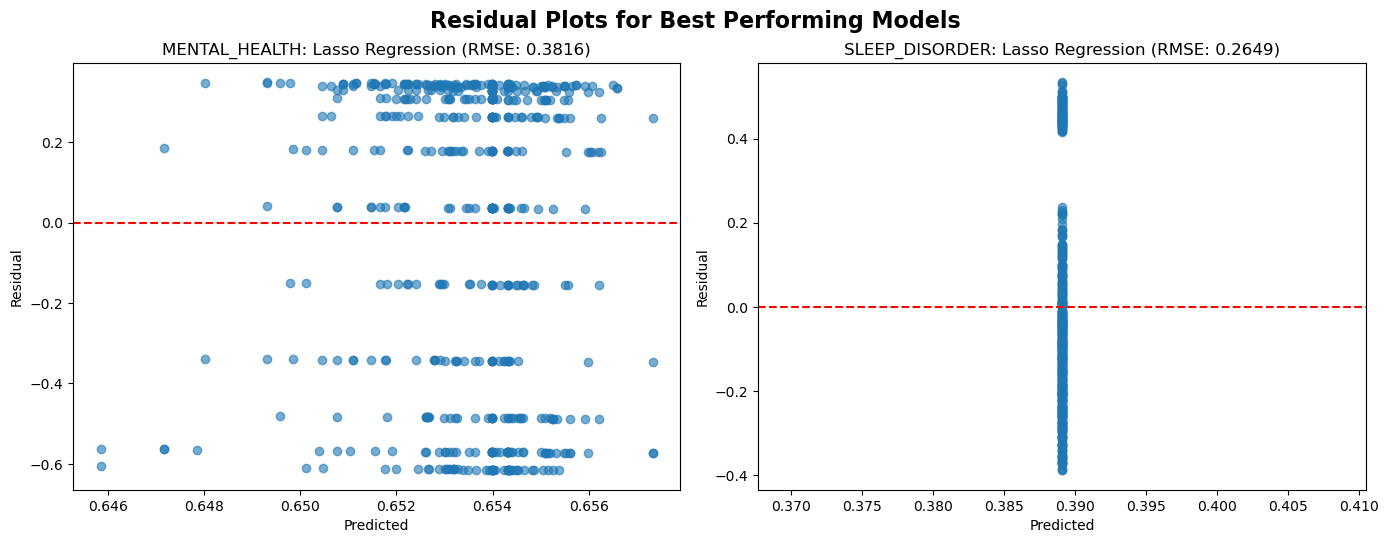


CONFUSION MATRICES

Dataset: CARDIOVASCULAR
  Model: Logistic Regression (Ridge)


,Pred_0,Pred_1
Actual_0,405,0
Actual_1,122,0


  Model: Logistic Regression (Lasso)


,Pred_0,Pred_1
Actual_0,405,0
Actual_1,122,0


  Model: Random Forest Classifier


,Pred_0,Pred_1
Actual_0,386,19
Actual_1,115,7


  Model: SVM (Linear)


,Pred_0,Pred_1
Actual_0,405,0
Actual_1,122,0


  Model: SVM (RBF)


,Pred_0,Pred_1
Actual_0,387,18
Actual_1,118,4


  Model: k-NN Classifier


,Pred_0,Pred_1
Actual_0,383,22
Actual_1,113,9



Dataset: RESPIRATORY
  Model: Logistic Regression (Ridge)


,Pred_0,Pred_1
Actual_0,403,0
Actual_1,124,0


  Model: Logistic Regression (Lasso)


,Pred_0,Pred_1
Actual_0,403,0
Actual_1,124,0


  Model: Random Forest Classifier


,Pred_0,Pred_1
Actual_0,396,7
Actual_1,118,6


  Model: SVM (Linear)


,Pred_0,Pred_1
Actual_0,403,0
Actual_1,124,0


  Model: SVM (RBF)


,Pred_0,Pred_1
Actual_0,401,2
Actual_1,123,1


  Model: k-NN Classifier


,Pred_0,Pred_1
Actual_0,366,37
Actual_1,113,11


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize lists to store results
all_regression_results = []
all_classification_results = []
all_coefficients = []

# Initialize dictionaries for plots
all_residual_plots = {}
all_confusion_matrices = {}

print("Running Predictive Modeling Suite for All Datasets\n")

for name, dataset_with_info in datasets.items():
    print(f"Processing: {name.upper()}...")

    dataset = dataset_with_info["data"]
    feature_types = dataset_with_info["feature_types"]

    model_results = run_modeling_suite(
        dataset,
        "target",
        feature_types=feature_types,
    )

    target_type = model_results["target_type"]
    coef_df = model_results.get("coefficients", pd.DataFrame())

    if target_type == "continuous":
        # Collect Regression Results
        reg_df = model_results.get("regression_results", pd.DataFrame())
        if not reg_df.empty:
            reg_df["Dataset"] = name.upper()
            all_regression_results.append(reg_df)

        # Collect Coefficients (regression)
        if not coef_df.empty:
            coef_df["Dataset"] = name.upper()
            all_coefficients.append(coef_df)

        # Collect Residual Plots
        residuals = model_results.get("residuals", {})
        if residuals:
            all_residual_plots[name] = residuals

    else:
        # Collect Classification Results
        clf_df = model_results.get("classification_results", pd.DataFrame())
        if not clf_df.empty:
            clf_df["Dataset"] = name.upper()
            all_classification_results.append(clf_df)

        # Collect Coefficients (classification)
        if not coef_df.empty:
            coef_df["Dataset"] = name.upper()
            all_coefficients.append(coef_df)

        # Collect Confusion Matrices
        cms = model_results.get("confusion_matrices", {})
        if cms:
            all_confusion_matrices[name] = cms

# --- Display Summary Results ---

final_reg_df = pd.DataFrame()
final_clf_df = pd.DataFrame()
final_coef_df = pd.DataFrame()

if all_regression_results:
    print()
    final_reg_df = pd.concat(all_regression_results, ignore_index=True)
    cols = ["Dataset"] + [c for c in final_reg_df.columns if c != "Dataset"]
    final_reg_df = final_reg_df[cols]

if all_classification_results:
    print()
    final_clf_df = pd.concat(all_classification_results, ignore_index=True)
    cols = ["Dataset"] + [c for c in final_clf_df.columns if c != "Dataset"]
    final_clf_df = final_clf_df[cols]

if all_coefficients:
    print()
    final_coef_df = pd.concat(all_coefficients, ignore_index=True)
    cols = ["Dataset"] + [c for c in final_coef_df.columns if c != "Dataset"]
    final_coef_df = final_coef_df[cols]

# Per-dataset ordered view: results first, then coefficients
if not (final_reg_df.empty and final_clf_df.empty and final_coef_df.empty):
    print()
    print(f"PER-DATASET RESULTS AND COEFFICIENTS")
    for dataset_name in [name.upper() for name in datasets.keys()]:
        print(f"\nDataset: {dataset_name}")
        reg_subset = (
            final_reg_df[final_reg_df["Dataset"] == dataset_name]
            if not final_reg_df.empty
            else pd.DataFrame()
        )
        if not reg_subset.empty:
            print("  Regression results:")
            display(reg_subset)
        clf_subset = (
            final_clf_df[final_clf_df["Dataset"] == dataset_name]
            if not final_clf_df.empty
            else pd.DataFrame()
        )
        if not clf_subset.empty:
            print("  Classification results:")
            display(clf_subset)
        coef_subset = (
            final_coef_df[final_coef_df["Dataset"] == dataset_name]
            if not final_coef_df.empty
            else pd.DataFrame()
        )
        if not coef_subset.empty:
            print("  Coefficients / importances:")
            display(coef_subset)

if all_residual_plots and not final_reg_df.empty:
    print()
    print(f"RESIDUAL PLOTS (Best Model per Dataset)")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(
        "Residual Plots for Best Performing Models", fontsize=16, fontweight="bold"
    )
    axes = axes.flatten()

    datasets_list = final_reg_df["Dataset"].unique()

    for i, dataset_name in enumerate(datasets_list):
        if i >= 4:
            break  # Limit to 4 plots
        ax = axes[i]

        dataset_results = final_reg_df[final_reg_df["Dataset"] == dataset_name]
        if dataset_results.empty:
            ax.set_visible(False)
            continue

        # Find model with lowest RMSE
        best_model_row = dataset_results.loc[dataset_results["RMSE"].idxmin()]
        best_model_name = best_model_row["model"]

        # Find the original key for all_residual_plots
        residuals_key = None
        for key in all_residual_plots.keys():
            if key.upper() == dataset_name:
                residuals_key = key
                break

        if residuals_key and best_model_name in all_residual_plots[residuals_key]:
            payload = all_residual_plots[residuals_key][best_model_name]

            ax.scatter(payload["pred"], payload["resid"], alpha=0.6)
            ax.axhline(0, color="red", linestyle="--")
            ax.set_title(
                f"{dataset_name}: {best_model_name} (RMSE: {best_model_row['RMSE']:.4f})"
            )
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Residual")
        else:
            ax.text(0.5, 0.5, "Data not available", ha="center", va="center")
            ax.set_title(f"{dataset_name}")

    # Hide unused subplots
    for j in range(i + 1, 4):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

if all_confusion_matrices:
    print()
    print(f"CONFUSION MATRICES")
    for name, cms in all_confusion_matrices.items():
        print(f"\nDataset: {name.upper()}")
        for model_name, cm_df in cms.items():
            print(f"  Model: {model_name}")
            display(cm_df)

In [28]:
# Post-hoc summary: pick lowest-RMSE model per dataset (regression)
# and pick best-F1 model per dataset (classification); report strongest features with relative impact
import numpy as np

if ('final_reg_df' not in globals() or final_reg_df.empty) and ('final_clf_df' not in globals() or final_clf_df.empty):
    print("No results available; nothing to summarize.")
else:
    tol = 0.05  # 5% margin to consider impacts effectively similar

    # --- Regression (uses RMSE) ---
    if 'final_reg_df' in globals() and not final_reg_df.empty:
        datasets_with_rmse = final_reg_df['Dataset'].unique()
        for ds in datasets_with_rmse:
            ds_rows = final_reg_df[final_reg_df['Dataset'] == ds]
            best_row = ds_rows.loc[ds_rows['RMSE'].idxmin()]
            best_model = best_row['model']
            best_rmse = best_row['RMSE']
            print(f"\n=== {ds} (Regression) ===")
            print(f"Best model (lowest RMSE): {best_model} | RMSE={best_rmse:.4f}")

            coef_rows = final_coef_df[(final_coef_df['Dataset'] == ds) & (final_coef_df['model'] == best_model)].copy()
            if coef_rows.empty:
                print("No coefficients/importances stored for this model.")
                continue

            coef_rows['abs_coef'] = coef_rows['coefficient'].abs()
            coef_rows = coef_rows.sort_values('abs_coef', ascending=False)

            top = coef_rows.iloc[0]
            top_abs = top['abs_coef']
            top_feat = top['feature']
            top_coef = top['coefficient']

            second_abs = coef_rows.iloc[1]['abs_coef'] if len(coef_rows) > 1 else 0.0

            if second_abs == 0:
                relation = "dominant (no other non-zero features)" if top_abs > 0 else "all coefficients are zero"
            else:
                ratio = top_abs / second_abs
                relation = f"impact is similar to other features (top/next ratio ~{ratio:.2f})" if ratio <= 1 + tol else f"about {ratio:.2f}x the next strongest feature"

            print(f"Top feature: {top_feat} (coef={top_coef:.4f}, |coef|={top_abs:.4f}); {relation}")
            print("Next strongest features:")
            display(coef_rows.head(5)[['feature', 'coefficient', 'abs_coef']])

    # --- Classification (uses F1 to pick best) ---
    if 'final_clf_df' in globals() and not final_clf_df.empty:
        datasets_with_clf = final_clf_df['Dataset'].unique()
        for ds in datasets_with_clf:
            ds_rows = final_clf_df[final_clf_df['Dataset'] == ds]
            best_row = ds_rows.loc[ds_rows['F1'].idxmax()]
            best_model = best_row['model']
            best_f1 = best_row['F1']
            print(f"\n=== {ds} (Classification) ===")
            print(f"Best model (highest F1): {best_model} | F1={best_f1:.4f}")

            coef_rows = final_coef_df[(final_coef_df['Dataset'] == ds) & (final_coef_df['model'] == best_model)].copy()
            if coef_rows.empty:
                print("No coefficients/importances stored for this model.")
                continue

            coef_rows['abs_coef'] = coef_rows['coefficient'].abs()
            coef_rows = coef_rows.sort_values('abs_coef', ascending=False)

            top = coef_rows.iloc[0]
            top_abs = top['abs_coef']
            top_feat = top['feature']
            top_coef = top['coefficient']

            second_abs = coef_rows.iloc[1]['abs_coef'] if len(coef_rows) > 1 else 0.0

            if second_abs == 0:
                relation = "dominant (no other non-zero features)" if top_abs > 0 else "all coefficients are zero"
            else:
                ratio = top_abs / second_abs
                relation = f"impact is similar to other features (top/next ratio ~{ratio:.2f})" if ratio <= 1 + tol else f"about {ratio:.2f}x the next strongest feature"

            print(f"Top feature: {top_feat} (coef={top_coef:.4f}, |coef|={top_abs:.4f}); {relation}")
            print("Next strongest features:")
            display(coef_rows.head(5)[['feature', 'coefficient', 'abs_coef']])



=== MENTAL_HEALTH (Regression) ===
Best model (lowest RMSE): Lasso Regression | RMSE=0.3816
Top feature: solar_wint (coef=-0.0017, |coef|=0.0017); dominant (no other non-zero features)
Next strongest features:


,feature,coefficient,abs_coef
29,solar_wint,-0.001701,0.001701
28,solar_summ,-0.000000,0.000000
30,noiseday_m,-0.000000,0.000000
31,noisenight,-0.000000,0.000000
32,building_height,-0.000000,0.000000



=== SLEEP_DISORDER (Regression) ===
Best model (lowest RMSE): Lasso Regression | RMSE=0.2649
Top feature: lst_mean (coef=-0.0000, |coef|=0.0000); all coefficients are zero
Next strongest features:


,feature,coefficient,abs_coef
252,lst_mean,-0.0,0.0
253,solar_summ,-0.0,0.0
254,pm10_mean,-0.0,0.0
255,pm25_mean,-0.0,0.0
256,noiseday_m,-0.0,0.0



=== CARDIOVASCULAR (Classification) ===
Best model (highest F1): k-NN Classifier | F1=0.6806
Top feature: education_level (coef=0.0132, |coef|=0.0132); about 1.40x the next strongest feature
Next strongest features:


,feature,coefficient,abs_coef
216,education_level,0.013213,0.013213
218,typology_C,0.009411,0.009411
217,age_bin,0.008460,0.008460
219,typology_E,0.006084,0.006084
203,lst_mean,0.005608,0.005608



=== RESPIRATORY (Classification) ===
Best model (highest F1): Random Forest Classifier | F1=0.6811
Top feature: education_level (coef=0.3069, |coef|=0.3069); about 2.23x the next strongest feature
Next strongest features:


,feature,coefficient,abs_coef
342,education_level,0.306866,0.306866
337,solar_wint,0.137616,0.137616
338,frontal_area_index,0.136816,0.136816
336,solar_summ,0.136016,0.136016
340,length_se-nw,0.129350,0.129350
